In [3]:
import os
import pandas as pd
import numpy as np
import xarray as xr
#import seaborn as sns
import modules.provide_datasets as data
#import modules.preprocess_data as preprocess
%load_ext autoreload
%autoreload 2

month_name_to_number = {"JAN":1, "FEB":2, "MAR":3, "APR":4, "MAY":5, "JUN":6, "JUL":7, "AUG":8, "SEP":9, "OCT":10, "NOV":11, "DEC":12}

In [4]:
xr.__version__

'2022.11.0'

In [5]:
def read_data(model_name_as_string):
    """Read netcdf4 data files and concatenates them to one dataframe.
    Params:
     - model_name_as_string: string, the name of the model
     
     Returns:
      - hindcasts: dataframe
    """
    li_temp = []
    li_prec = []
    climate_vars = ["prec", "t2m"]
    directory_as_str = "data/" + model_name_as_string + "/"
    directory = os.fsencode(directory_as_str)
    # to print progress of reading files
    total_number_of_files = len([entry for entry in os.listdir(directory_as_str) if os.path.isfile(os.path.join(directory_as_str, entry))])
    counter = 0
    for file in os.listdir(directory):
        counter += 1
        filename = os.fsdecode(file)
        # info about hindcasts are part of the filename
        splitted_filename = filename.split("_") 
        init_month = splitted_filename[-3]
        year = splitted_filename[-2]
        if filename.endswith("nc"):
            df = (xr
                  .open_dataset(directory_as_str + filename, engine="netcdf4")
                  .to_dataframe()
                  .reset_index()
                  .assign(init_month=init_month, year=year, model=model_name_as_string)
                  .groupby(["model", "init_month", "year", "time", "lat", "lon"])
                  .mean())
            df = df.loc[:, [c for c in df.columns if c in climate_vars]]
            if filename.endswith("prec.nc"): li_prec.append(df)
            if filename.endswith("t2m.nc"): li_temp.append(df)
        print(str(counter) + "/" + str(total_number_of_files))
    
    print("concatenating temp and rain..")        
    hindcasts_prec = pd.concat(li_prec, axis=0, ignore_index=False)
    hindcasts_temp = pd.concat(li_temp, axis=0, ignore_index=False)
    hindcasts = hindcasts_prec.combine_first(hindcasts_temp).reset_index()
    
    print("basic preprocessing..")  
    # init_month as integer instead of string
    hindcasts["init_month"] = hindcasts["init_month"].replace(month_name_to_number)
    # Change to spatial encoding
    hindcasts["lon"] = hindcasts["lon"].apply(lambda x: x - 360 if x > 180 else x)
    # filter for Brazil
    hindcasts = hindcasts.loc[(hindcasts["lat"].between(-31, -21)) & (hindcasts["lon"].between(-55, -48)), :].reset_index(drop=True)
    # kelvin to celsius
    if model_name_as_string in ["BOM", "BCC"]: 
        hindcasts["t2m"] = hindcasts["t2m"].apply(lambda x: x - 273.15)
        # assign and filter zones based on coordinates
        coordinates_to_zone = {"-27.5-52.5":1, "-22.5-50.0":2, "-25.0-52.5":3, "-25.0-50.0":4}
        hindcasts["zone"] = hindcasts.loc[:, ["lat", "lon"]].apply(lambda x: coordinates_to_zone[str(x[0])+str(x[1])] if (str(x[0])+str(x[1]) in coordinates_to_zone) else np.nan, axis=1)
        hindcasts = hindcasts.dropna(subset=["zone"]).reset_index(drop=True).drop(columns=["lat", "lon"])
    
    return hindcasts
    

In [6]:
df = read_data("bcc test")

1/15
2/15
3/15
4/15
5/15
6/15
7/15
8/15
9/15


KeyboardInterrupt: 

In [44]:
#df.to_csv("BCC_hindcasts.csv", index=False)

In [65]:
bom = pd.read_csv("BOM_hindcasts.csv")
bcc = pd.read_csv("BCC_hindcasts.csv")

In [66]:
coordinates_to_zone = {"-27.5-52.5":1, "-22.5-50.0":2, "-25.0-52.5":3, "-25.0-50.0":4}
bom["zone"] = bom.loc[:, ["lat", "lon"]].apply(lambda x: coordinates_to_zone[str(x[0])+str(x[1])] if (str(x[0])+str(x[1]) in coordinates_to_zone) else np.nan, axis=1)
bom = bom.dropna(subset=["zone"]).reset_index(drop=True).drop(columns=["lat", "lon"])

In [67]:

bom["time"] = pd.to_datetime(bom["time"])
bom["month"] = bom["time"].dt.month
bom = bom[["model", "init_month", "zone", "month", "year", "time", "t2m", "prec"]]

In [68]:
bom.head()

,model,init_month,zone,month,year,time,t2m,prec
0,BOM,4,1.0,4,1993,1993-04-01,19.008386,7.176180
1,BOM,4,3.0,4,1993,1993-04-01,20.428674,7.169197
2,BOM,4,4.0,4,1993,1993-04-01,18.901697,5.727837
3,BOM,4,2.0,4,1993,1993-04-01,22.458826,4.238339
4,BOM,4,1.0,5,1993,1993-05-01,14.911127,6.725364


In [72]:
bcc["month"] = pd.to_datetime(bcc["time"]).dt.month

In [74]:
bcc = bcc[["model", "init_month", "zone", "month", "year", "time", "t2m", "prec"]]

In [77]:
bcc.to_csv("BCC_hindcasts.csv", index=False)

In [78]:
bom.to_csv("BOM_hindcasts.csv", index=False)

In [79]:
bom = pd.read_csv("BOM_hindcasts.csv")
bcc = pd.read_csv("BCC_hindcasts.csv")

In [128]:
df = pd.concat([bom, bcc], ignore_index=True)

In [129]:
df["time"] = pd.to_datetime(df["time"])

In [130]:
df = df.loc[df["init_month"].isin(list(range(5,11)))].reset_index(drop=True)

In [131]:
df = df.loc[df["time"].dt.month.between(8,10)].set_index(["model", "init_month", "zone", "year", "month", "time"]).sort_index().drop_duplicates()

In [132]:
df

t2m      prec
model init_month zone year month time                           
BCC   5          1.0  1993 8     1993-08-01  12.385309  1.855946
                           9     1993-09-01  15.075952  2.788637
                           10    1993-10-01  17.784998  2.992980
                      1994 8     1994-08-01  13.135217  1.311258
                           9     1994-09-01  15.209100  2.253363
...                                                ...       ...
BOM   10         4.0  2012 10    2012-10-01  18.743219  6.109427
                      2013 10    2013-10-01  17.696466  6.798573
                      2014 10    2014-10-01  17.955255  5.772328
                      2015 10    2015-10-01  18.390710  8.439065
                      2016 10    2016-10-01  18.078790  5.986126

[2868 rows x 2 columns]

In [136]:
observations = data.read_observed_weather() # daily; 1993-2016

In [141]:
observations = observations.loc[:, ["tmean", "rain"]].reset_index()
observations = observations.loc[observations["month"].between(8,10)]

In [144]:
observations = observations.groupby(["model", "init_month", "zone", "year", "month"]).mean()

In [151]:
df.columns = ["tmean", "rain"]

In [157]:
observations

tmean      rain
model init_month zone year month                     
WS    11         1    1993 8      15.217742  0.490323
                           9      14.960000  4.550000
                           10     20.109677  4.974194
                      1994 8      15.691935  1.483871
                           9      17.461667  5.390000
...                                     ...       ...
                 4    2015 9      20.775000  4.373333
                           10     20.148387  5.696774
                      2016 8      14.746774  5.219355
                           9      17.261667  1.920000
                           10     20.164516  8.290323

[288 rows x 2 columns]

In [160]:
df = df.reset_index().drop(columns=["time"]).set_index(["model", "init_month", "zone", "year", "month"])

In [167]:
df.loc[("BCC", 5, 1, 1994)]

,tmean,rain
month,,
8,13.135217,1.311258
9,15.209100,2.253363
10,18.030695,3.190443


In [184]:
import warnings
warnings.filterwarnings('error')
hindcasts_temp_adjusted = preprocess.adjust_temperature_bias(observations, df)

RuntimeWarning: invalid value encountered in true_divide

<AxesSubplot:ylabel='Density'>

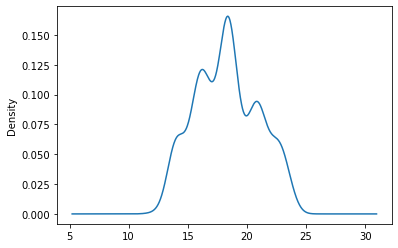

In [186]:
df["tmean"].plot(kind="density")

<AxesSubplot:ylabel='Density'>

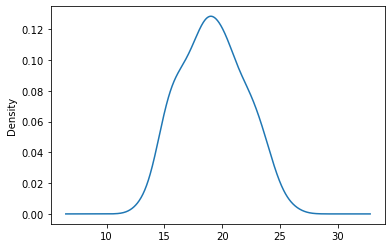

In [187]:
observations["tmean"].plot(kind="density")